# 01 - BLOCS SMAD Segments EDA

Exploratory data analysis for the BLOCS segment manifest and the acoustic stats / QC flags produced by `build_acoustic_stats.py`.

## How to use this notebook

This notebook assumes you have:

1. Synced audio and segments locally with `python scripts/sync_b2_data.py`.
2. Built the acoustic-stats manifest with `python -m data_processing.build_acoustic_stats`.

If you want to experiment freely, make a personal copy in `notebooks/local` (e.g., `01_smad_segments_eda_<yourname>.ipynb`) and work in that file.

## 1. Load configuration and datasets

In this section we load project settings, point to the BLOCS metadata directory, and open the base segment manifest (`blocs_smad_segments`) and the acoustic-stats–augmented manifest (`blocs_smad_v1`).

In [6]:
from pathlib import Path
import sys

ROOT = Path.cwd().resolve()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent
sys.path.append(str(ROOT))

import pandas as pd
from datasets import load_from_disk
from config import get_settings
from utils.config_utils import load_env, add_project_root_to_path
from utils.dams_types import BLOCS_SMAD_SEGMENTS, BLOCS_SMAD_V1

load_env()
add_project_root_to_path()

# Load project settings for file paths and parameters.
settings = get_settings()
metadata_dir = Path(settings.metadata_path)
segments_dir = Path(settings.segments_path)

# Define manifest paths.
base_manifest_path = metadata_dir / BLOCS_SMAD_SEGMENTS
acoustic_manifest_path = metadata_dir / BLOCS_SMAD_V1

# Load HF datasets to pandas dataframes.
ds_segments = load_from_disk(base_manifest_path)
ds_acoustic = load_from_disk(acoustic_manifest_path)
df_segments = ds_segments.to_pandas()
df_acoustic = ds_acoustic.to_pandas()

len(df_segments), len(df_acoustic) # Should be the same number of rows.

(6196, 6196)

### 1.1 HuggingFace Datasets

This project uses HuggingFace Datasets. If unfamiliar, you may want to check out their tutorials: https://huggingface.co/docs/datasets/en/index

## 2. Inspect schema and basic statistics

Here we inspect columns, dtypes, and simple descriptive statistics for segment-level metadata.
The goal is to get a feel for what a “segment row” looks like before training.

+ `split`: train/val/test split designation. Default is unsplit.
+ `label_source`: source of transcription labels (none, gold, or specific model). Default is none.
+ `*_label`: binary multi-label targets for presence of speech, music, or noise (0/1).
+ `*_score`: teacher confidence scores for specific label types (0.0–1.0).

In [7]:
# Preview first few rows of segment-level metadata from blocs_smad_segments.

display(df_segments.head())

,raw_file,segment_path,start_time,end_time,split,label_source,speech_label,music_label,noise_label,speech_score,music_score,noise_score
0,001_NO_RAD_0001.wav,001_NO_RAD_0001_s0001.wav,0.0,10.0,unsplit,none,0,0,0,None,None,None
1,001_NO_RAD_0001.wav,001_NO_RAD_0001_s0002.wav,5.0,15.0,unsplit,none,0,0,0,None,None,None
2,001_NO_RAD_0001.wav,001_NO_RAD_0001_s0003.wav,10.0,20.0,unsplit,none,0,0,0,None,None,None
3,001_NO_RAD_0001.wav,001_NO_RAD_0001_s0004.wav,15.0,25.0,unsplit,none,0,0,0,None,None,None
4,001_NO_RAD_0001.wav,001_NO_RAD_0001_s0005.wav,20.0,30.0,unsplit,none,0,0,0,None,None,None


In [8]:
# Preview first few rows of acoustic stats and QC flags from blocs_smad_v1.

display(df_acoustic.head())

,raw_file,segment_path,start_time,end_time,split,label_source,speech_label,music_label,noise_label,speech_score,...,is_too_quiet,silence_ratio,is_mostly_silence,clipping_ratio,is_heavily_clipped,zero_crossing_rate,is_high_zcr,snr_db,energy_variance,had_error
0,001_NO_RAD_0001.wav,001_NO_RAD_0001_s0001.wav,0.0,10.0,unsplit,none,0,0,0,None,...,False,0.025569,False,0.0,False,0.070200,False,16.212700,0.677544,False
1,001_NO_RAD_0001.wav,001_NO_RAD_0001_s0002.wav,5.0,15.0,unsplit,none,0,0,0,None,...,False,0.026387,False,0.0,False,0.073144,False,16.776026,0.717201,False
2,001_NO_RAD_0001.wav,001_NO_RAD_0001_s0003.wav,10.0,20.0,unsplit,none,0,0,0,None,...,False,0.026944,False,0.0,False,0.073194,False,16.783127,0.714995,False
3,001_NO_RAD_0001.wav,001_NO_RAD_0001_s0004.wav,15.0,25.0,unsplit,none,0,0,0,None,...,False,0.026456,False,0.0,False,0.079044,False,16.733902,0.695055,False
4,001_NO_RAD_0001.wav,001_NO_RAD_0001_s0005.wav,20.0,30.0,unsplit,none,0,0,0,None,...,False,0.024344,False,0.0,False,0.116406,False,16.303371,0.604736,False


In [9]:
# Get familiar with the acoustic names and dtypes.

df_acoustic.dtypes

raw_file               object
segment_path           object
start_time            float64
end_time              float64
split                  object
label_source           object
speech_label            int64
music_label             int64
noise_label             int64
speech_score           object
music_score            object
noise_score            object
duration_sec          float64
is_too_short             bool
rms_db                float64
is_too_quiet             bool
silence_ratio         float64
is_mostly_silence        bool
clipping_ratio        float64
is_heavily_clipped       bool
zero_crossing_rate    float64
is_high_zcr              bool
snr_db                float64
energy_variance       float64
had_error                bool
dtype: object

In [10]:
# Basic descriptive statistics for numeric columns.

with pd.option_context('display.float_format', '{:.6f}'.format):
    display(df_acoustic.describe(include="number").T)


,count,mean,std,min,25%,50%,75%,max
start_time,6196.000000,3955.919141,2378.654055,0.000000,1935.000000,3870.000000,5805.000000,9215.000000
end_time,6196.000000,3965.912983,2378.644655,10.000000,1945.000000,3880.000000,5815.000000,9218.472000
speech_label,6196.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
music_label,6196.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
noise_label,6196.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
duration_sec,6196.000000,9.993841,0.194774,2.064000,10.000000,10.000000,10.000000,10.000000
rms_db,6196.000000,-27.223895,7.693919,-50.239227,-33.699079,-27.790848,-22.064301,-7.650597
silence_ratio,6196.000000,0.238450,0.152941,0.002531,0.125775,0.214259,0.323072,0.978850
clipping_ratio,6196.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000150
zero_crossing_rate,6196.000000,0.153717,0.039065,0.005206,0.126156,0.155644,0.180922,0.352969


## 3. Acoustic flags: prevalence and distribution

In this section we summarize how often each acoustic flag fires (too quiet, mostly silence, heavily clipped, too short, had error), both as counts and percentages. This helps sanity-check the thresholds used in `build_acoustic_stats.py`.

In [11]:
# Summarize prevalence of acoustic QC flags.

# Identify all boolean or 0/1 flag columns.
flag_cols = [
    col for col in df_acoustic.columns
    if col.endswith('_flag') or col in
       ['too_quiet', 'mostly_silence', 'heavily_clipped',
        'too_short', 'had_error']
    if col in df_acoustic.columns
]

# Compute counts and percentages.
flag_summary = pd.DataFrame({
    'count': df_acoustic[flag_cols].sum(),
    'percent': (df_acoustic[flag_cols].mean() * 100)
}).sort_values('percent', ascending=False)

with pd.option_context('display.float_format', '{:.2f}'.format):
    display(flag_summary)

,count,percent
had_error,0,0.00


## 4. Distributions of core acoustic features

We visualize the distributions of key numeric features (for example duration, RMS energy, peak amplitude) and look for outliers or pathological patterns that might affect training.

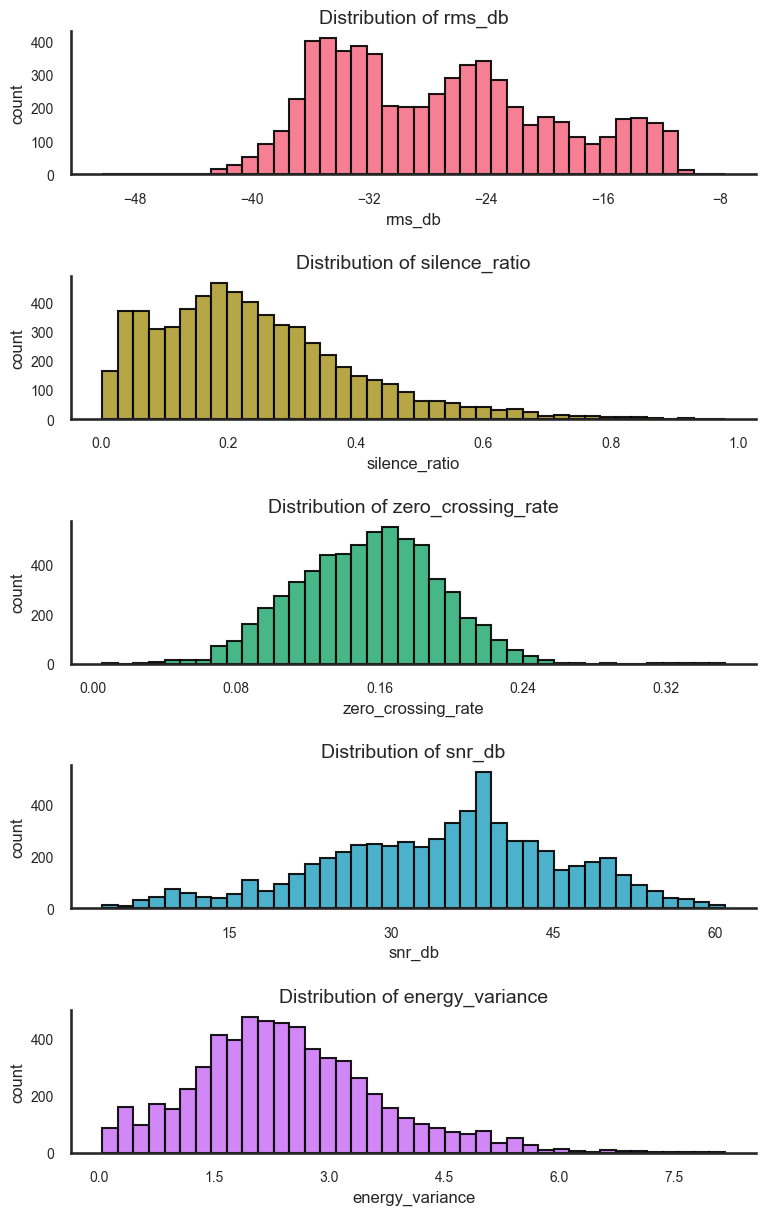

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

def set_plot_style() -> None:
    """Set a clean, readable style for EDA plots without grid lines."""
    sns.set_style("white", {"axes.grid": False})
    sns.set_context("talk")


def style_generic_plot(ax, title: str, xlabel: str, ylabel: str) -> None:
    """Apply consistent styling to a single axis."""
    sns.despine(ax=ax)  # removes top and right spines

    # turn OFF all gridlines
    ax.grid(False)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.set_facecolor("white")


set_plot_style()

# Core acoustic features we care about for QC and modeling.
acoustic_cols = [
    "rms_db",
    "silence_ratio",
    "zero_crossing_rate",
    "snr_db",
    "energy_variance",
]

# Keep only columns that exist in the current manifest.
acoustic_cols = [c for c in acoustic_cols if c in df_acoustic.columns]

# HUSL palette
colors = sns.color_palette("husl", n_colors=len(acoustic_cols))

fig, axes = plt.subplots(len(acoustic_cols), 1, figsize=(8, 2.5 * len(acoustic_cols)))

if len(acoustic_cols) == 1:
    axes = [axes]

for ax, col, color in zip(axes, acoustic_cols, colors):
    ax.hist(df_acoustic[col], bins=40, color=color, edgecolor="black", alpha=0.9)
    style_generic_plot(
        ax,
        title=f"Distribution of {col}",
        xlabel=col,
        ylabel="count",
    )

plt.tight_layout()
plt.show()

## 5. Listen to example segments

To ground the numbers in actual audio, we sample a few segments and listen to them. We can filter by QC flags (for example “good” segments versus “mostly silence”) to verify that the flags match our intuition.

In [13]:
from IPython.display import HTML, Audio, display

from utils.audio_io import load_waveform


def _resolve_segment_path(row) -> Path:
    """Resolve the on-disk path for a segment from a row."""
    candidate_cols = ["segment_path", "segment_relpath", "segment_file"]
    for col in candidate_cols:
        if col in row.index:
            return segments_dir / row[col]
    raise KeyError(
        "Could not find a segment path column. "
        "Update `_resolve_segment_path` with the correct column name."
    )


def play_random_segment(df, query: str | None = None, sample_rate: int = 16_000) -> None:
    """Sample a random segment (optionally filtered by a query) and play it."""
    subset = df.query(query) if query else df
    if subset.empty:
        print("No rows matched the query.")
        return

    row = subset.sample(1).iloc[0]
    audio_path = _resolve_segment_path(row)

    # Clean filename for display
    segment_name = audio_path.name

    print(f"\n▶ Segment: {segment_name}")
    print(f"   Path: {audio_path}")
    print()

    waveform, sr = load_waveform(audio_path)
    sr = sr or sample_rate

    # Show the row metadata and play the audio.
    display(row)
    display(Audio(waveform.squeeze().numpy(), rate=sr))

In [15]:
# Let's also define a function to play a grid of segments.

def play_segment_grid(
    df,
    query: str | None = None,
    n: int = 6,
    n_cols: int = 3,
    sample_rate: int = 16_000,
) -> None:
    """Display a small grid of audio segments with inline players."""
    subset = df.query(query) if query else df
    if subset.empty:
        print("No rows matched the query.")
        return

    n = min(n, len(subset))
    sampled = subset.sample(n, random_state=0)

    cell_html_blocks: list[str] = []

    for _, row in sampled.iterrows():
        audio_path = _resolve_segment_path(row)
        waveform, sr = load_waveform(audio_path)
        sr = sr or sample_rate

        segment_name = audio_path.name

        # Build an embedded audio player for this segment
        audio_widget = Audio(waveform.squeeze().numpy(), rate=sr, embed=True)
        audio_html = audio_widget._repr_html_()

        # Wrap filename + audio in a small card
        card_html = f"""
        <div style="font-size:12px; margin-bottom:4px; font-family:monospace;">
            {segment_name}
        </div>
        {audio_html}
        """
        cell_html_blocks.append(card_html)

    # Arrange cards into a table grid
    rows_html: list[str] = []
    for i in range(0, len(cell_html_blocks), n_cols):
        cells = cell_html_blocks[i : i + n_cols]
        row_html = "".join(
            f"<td style='padding:8px; vertical-align:top;'>{cell}</td>"
            for cell in cells
        )
        rows_html.append(f"<tr>{row_html}</tr>")

    table_html = "<table><tbody>" + "".join(rows_html) + "</tbody></table>"
    display(HTML(table_html))

In [16]:


# 1) Completely random segment
play_random_segment(df_acoustic)

# 2) A "good" segment that passed all QC flags (uncomment if these columns exist)
# play_random_segment(
#     df_acoustic,
#     query="(~too_quiet) and (~mostly_silence) and (~heavily_clipped) and (~too_short) and (~had_error)",
# )

# 3) A segment that is mostly silence (uncomment if `mostly_silence` exists)
# play_random_segment(df_acoustic, query="mostly_silence")


▶ Segment: 001_NO_RAD_0001_s0012.wav
   Path: /Users/benji/Desktop/columbia/dams/data/segments/001_NO_RAD_0001_s0012.wav



RuntimeError: Could not load libtorchcodec. Likely causes:
          1. FFmpeg is not properly installed in your environment. We support
             versions 4, 5, 6, 7, and 8. On Windows, ensure you've installed
             the "full-shared" version which ships DLLs.
          2. The PyTorch version (2.9.1) is not compatible with
             this version of TorchCodec. Refer to the version compatibility
             table:
             https://github.com/pytorch/torchcodec?tab=readme-ov-file#installing-torchcodec.
          3. Another runtime dependency; see exceptions below.
        The following exceptions were raised as we tried to load libtorchcodec:
        
[start of libtorchcodec loading traceback]
FFmpeg version 8: Could not load this library: /Users/benji/Desktop/columbia/dams/.venv/lib/python3.13/site-packages/torchcodec/libtorchcodec_core8.dylib
FFmpeg version 7: Could not load this library: /Users/benji/Desktop/columbia/dams/.venv/lib/python3.13/site-packages/torchcodec/libtorchcodec_core7.dylib
FFmpeg version 6: Could not load this library: /Users/benji/Desktop/columbia/dams/.venv/lib/python3.13/site-packages/torchcodec/libtorchcodec_core6.dylib
FFmpeg version 5: Could not load this library: /Users/benji/Desktop/columbia/dams/.venv/lib/python3.13/site-packages/torchcodec/libtorchcodec_core5.dylib
FFmpeg version 4: Could not load this library: /Users/benji/Desktop/columbia/dams/.venv/lib/python3.13/site-packages/torchcodec/libtorchcodec_core4.dylib
[end of libtorchcodec loading traceback].

In [ ]:
# 6 random segments from the whole distribution
play_segment_grid(df_acoustic, n=6, n_cols=3)

# 6 segments that are mostly silence (if that flag exists)
# play_segment_grid(df_acoustic, query="mostly_silence", n=6, n_cols=3)

# 6 "good" segments with no QC issues
# play_segment_grid(
#     df_acoustic,
#     query="(~too_quiet) and (~mostly_silence) and (~heavily_clipped) and (~too_short) and (~had_error)",
#     n=6,
#     n_cols=3,
# )

## 6. Correlations among acoustic features

To understand how the core acoustic statistics relate to each other and whether they form meaningful structure for modeling, we compute correlation matrices and inspect which features co-vary. This helps us see whether the dataset naturally separates into regimes (for example speech-like, music-like, noise-like).

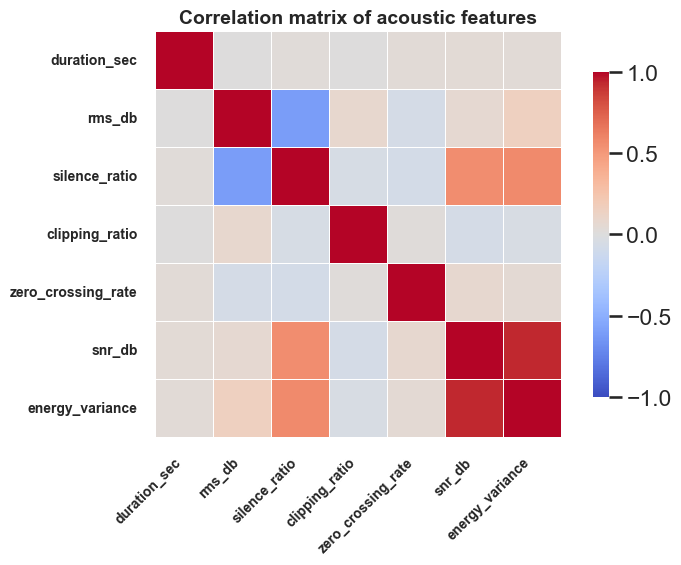

In [17]:
# Correlation matrix for numeric acoustic features.

numeric_cols = df_acoustic.select_dtypes(include="number").columns
exclude_cols = [
    "speech_label", "music_label", "noise_label",
    "speech_score", "music_score", "noise_score",
    "start_time", "end_time",
]
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

corr = df_acoustic[numeric_cols].corr()

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0.0,
    square=True,
    cbar_kws={"shrink": 0.8},
    xticklabels=numeric_cols,
    yticklabels=numeric_cols,
    linewidths=0.5,       # <-- add this
    linecolor="white",    # <-- and this
    vmin=-1.0,
    vmax=1.0,
)

# Title and axis label styling
ax.set_title(
    "Correlation matrix of acoustic features",
    fontsize=14,
    fontweight="bold",
)

# Tilt x-axis labels so they are readable.
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    fontsize=10,
    fontweight="bold",
)

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    fontsize=10,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

## 7. Distribution of gold labels (speech, music, noise)

This section activates once gold labels are mapped onto segments. For now, it will print a message if no label_source == "gold" rows exist.

In [18]:
# Check per class distributions of gold labels.

label_cols = ['speech_label', 'music_label', 'noise_label']

df_gold = df_acoustic[df_acoustic['label_source'] == 'gold'].copy()

if df_gold.empty:
    print("No gold labels found yet (label_source == 'gold'). "
          "Run the gold-to-segment mapping pipeline first.")
else:
    # Per-class prevalence
    print("Per-class prevalence among gold labels:")
    display(df_gold[label_cols].mean().to_frame('prevalence'))

    # Multi-label combo distribution
    combo = (
        df_gold[label_cols]
        .astype(int)
        .astype(str)
        .agg(''.join, axis=1)
    )
    print("\nMulti-label pattern distribution (e.g., 100 = speech only):")
    display(combo.value_counts(normalize=True).to_frame('fraction'))

No gold labels found yet (label_source == 'gold'). Run the gold-to-segment mapping pipeline first.


## 8. Pairwise relationships between acoustic features

To capture simple nonlinear structure that correlations might miss, we look at selected 2D projections of the acoustic feature space (for example `rms_db` vs `snr_db`). This helps reveal distinct regimes (for example quiet speech, loud music) and potential overlapping regions.

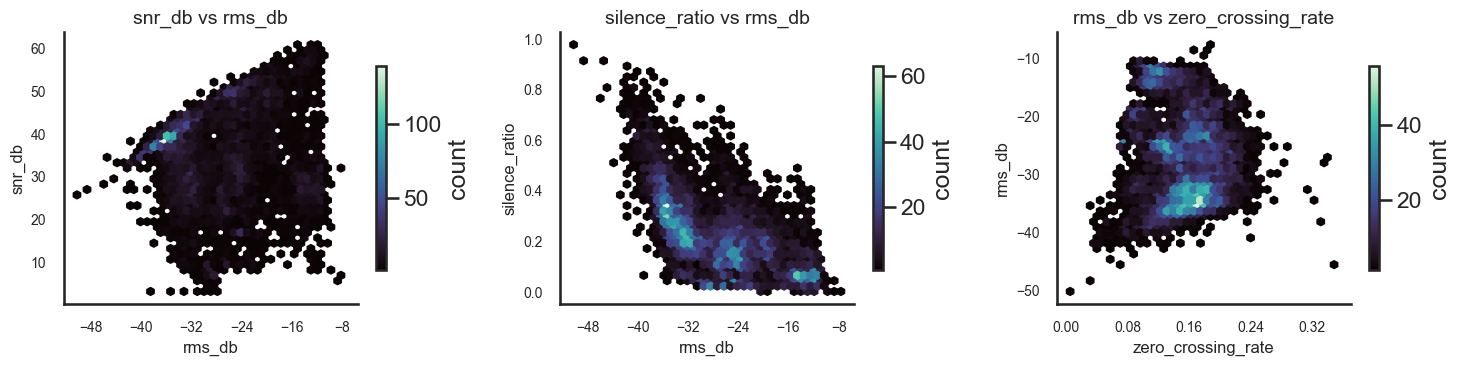

In [19]:
# Selected 2D acoustic feature relationships with stable hexbin plots.

import numpy as np

pair_specs = [
    ("rms_db", "snr_db"),
    ("rms_db", "silence_ratio"),
    ("zero_crossing_rate", "rms_db"),
]

# Collect all columns used in the pairs.
subset_cols = {c for pair in pair_specs for c in pair}
subset_cols = [c for c in subset_cols if c in df_acoustic.columns]

pair_sample = df_acoustic[subset_cols].copy()

# Replace infinities with NaN, then drop any NaNs.
pair_sample = pair_sample.replace([np.inf, -np.inf], np.nan).dropna()

# Subsample for readability if it is huge.
if len(pair_sample) > 20000:
    pair_sample = pair_sample.sample(20000, random_state=0)

fig, axes = plt.subplots(1, len(pair_specs), figsize=(5 * len(pair_specs), 4))

if len(pair_specs) == 1:
    axes = [axes]

for ax, (x_col, y_col) in zip(axes, pair_specs):
    if x_col not in pair_sample.columns or y_col not in pair_sample.columns:
        continue

    hb = ax.hexbin(
        pair_sample[x_col],
        pair_sample[y_col],
        gridsize=40,
        cmap="mako",
        mincnt=1,
    )
    style_generic_plot(
        ax,
        title=f"{y_col} vs {x_col}",
        xlabel=x_col,
        ylabel=y_col,
    )
    # Optional: colorbar per subplot
    cb = fig.colorbar(hb, ax=ax, shrink=0.75)
    cb.set_label("count")

plt.tight_layout()
plt.show()

## 9. PCA projection of acoustic features

We project the standardized acoustic features into a low-dimensional space using PCA. This provides a coarse view of how segments are arranged in feature space and whether there are obvious clusters or outliers.

In [20]:
def plot_pca_scatter(X_pca, explained_var):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Dark background to match your acoustic plots
    ax.set_facecolor('#1e1e1e')
    fig.patch.set_facecolor('#1e1e1e')

    # Single scatter color to match previous figures
    point_color = '#4db8ff'

    ax.scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        s=10,
        alpha=0.35,
        color=point_color,
        edgecolors='none'
    )

    ax.set_title(
        "PCA of acoustic features",
        fontsize=18,
        color='white',
        pad=12
    )
    ax.set_xlabel(
        f"PC1 ({explained_var[0]:.1f} percent var)",
        fontsize=14,
        color='white'
    )
    ax.set_ylabel(
        f"PC2 ({explained_var[1]:.1f} percent var)",
        fontsize=14,
        color='white'
    )

    ax.tick_params(axis='both', colors='white', labelsize=12)

    # White spines to match your correlation heatmap and hexbin style
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        spine.set_linewidth(1.2)

    plt.tight_layout()
    plt.show()

X_scaled shape: (6196, 5) | max abs: 5.1009185848053615


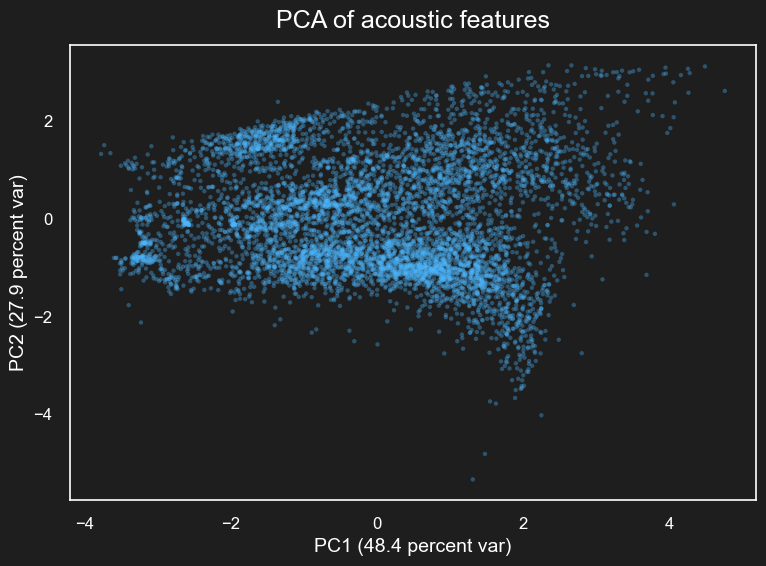

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Reuse the core acoustic columns from earlier.
pca_features = [
    "rms_db",
    "silence_ratio",
    "zero_crossing_rate",
    "snr_db",
    "energy_variance",
]
pca_features = [c for c in pca_features if c in df_acoustic.columns]

X = df_acoustic[pca_features].copy()

# 1) Clean: remove inf / -inf / NaN.
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# 2) Drop constant columns.
zero_var_cols = [c for c in X.columns if X[c].nunique() <= 1]
if zero_var_cols:
    print("Dropping zero-variance columns for PCA:", zero_var_cols)
    X = X.drop(columns=zero_var_cols)

if X.shape[1] < 2:
    raise ValueError(f"Need at least 2 non-constant numeric features, got {X.shape[1]}")

# 3) Standardize.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.asarray(X_scaled, dtype=np.float64)

# Final sanity check on the scaled matrix.
finite_mask = np.isfinite(X_scaled).all(axis=1)
if not finite_mask.all():
    dropped = (~finite_mask).sum()
    print(f"Dropping {dropped} rows with non-finite values after scaling.")
    X_scaled = X_scaled[finite_mask]
    X = X.iloc[finite_mask].reset_index(drop=True)

print(
    "X_scaled shape:", X_scaled.shape,
    "| max abs:", float(np.nanmax(np.abs(X_scaled)))
)

# 4) Fit PCA and check components.
pca = PCA(n_components=2, random_state=0)
pca.fit(X_scaled)

assert np.isfinite(pca.components_).all(), "Non-finite value in PCA components."

# 5) Transform inside a local error-state context to silence spurious warnings.
with np.errstate(divide="ignore", invalid="ignore", over="ignore"):
    X_pca = pca.transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=["pc1", "pc2"])
expl_var = pca.explained_variance_ratio_ * 100

# Optional subsample for plotting (use same sample for k-means viz if you want).
plot_sample = df_pca
if len(plot_sample) > 8000:
    plot_sample = plot_sample.sample(8000, random_state=0)

# Use the styled helper defined in the cell above
plot_pca_scatter(plot_sample[["pc1", "pc2"]].to_numpy(), expl_var)

## 10. Unsupervised clustering of segments

As a simple check for natural acoustic regimes, we run k-means on the standardized acoustic features and visualize the clusters in the PCA space. Clusters that do not align with our expectations (for example clear speech-like vs music-like vs noise-like groups) may indicate interesting structure or domain shifts.

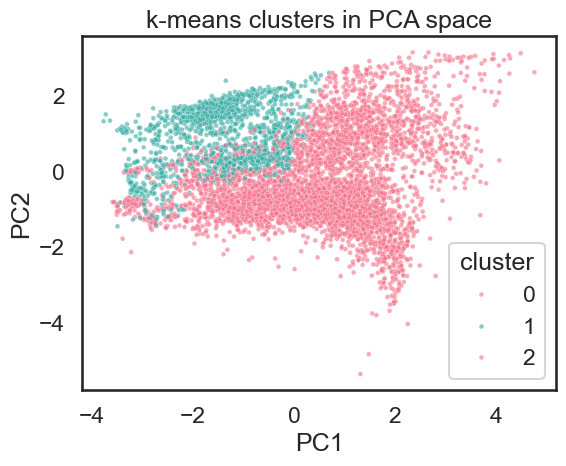

,count
0,2814
1,1510
2,1872


In [22]:
from sklearn.cluster import KMeans
import numpy as np

n_clusters = 3

# Extra sanity check (will raise if something is truly wrong)
assert np.isfinite(X_scaled).all(), "Non-finite values in X_scaled for k-means."

with np.errstate(divide="ignore", over="ignore", invalid="ignore"):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
    cluster_labels = kmeans.fit_predict(X_scaled)

df_pca_clusters = df_pca.copy()
df_pca_clusters["cluster"] = cluster_labels

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df_pca_clusters,
    x="pc1",
    y="pc2",
    hue="cluster",
    palette="husl",
    s=12,
    alpha=0.6,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("k-means clusters in PCA space")
plt.legend(title="cluster", loc="best")
plt.tight_layout()
plt.show()

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
display(cluster_counts.to_frame(name="count"))

In [23]:
# Interpret the clusters.

cluster_summary = (
    df_acoustic.assign(cluster=cluster_labels)[
        ["cluster", "rms_db", "silence_ratio", "zero_crossing_rate", "snr_db", "energy_variance"]
    ]
    .groupby("cluster")
    .agg(["mean", "std"])
)
display(cluster_summary)

rms_db           silence_ratio           zero_crossing_rate  \
              mean       std          mean       std               mean   
cluster                                                                   
0       -28.880891  7.570565      0.353976  0.136690           0.150550   
1       -19.413691  5.660270      0.089226  0.049999           0.125857   
2       -31.032986  4.014687      0.185160  0.080347           0.180950   

                      snr_db           energy_variance            
              std       mean       std            mean       std  
cluster                                                           
0        0.039364  43.836326  5.893116        3.446996  0.964766  
1        0.026870  27.057582  8.401486        1.743096  0.777055  
2        0.027521  27.475522  8.003868        1.562402  0.590094

### Summarize the acoustic results from the clusters to check your understanding.

+ `Cluster 0`:
+ `Cluster 1`:
+ `Cluster 2`:

## 11. Waveform and spectrogram views for individual segments

Finally, we visualize raw audio for selected segments as both waveforms and log-mel spectrograms. This helps connect acoustic statistics (for example `rms_db`, `silence_ratio`, `snr_db`) with the underlying time–frequency patterns that SMAD models will see.

In [24]:
import torch
import torchaudio

def plot_waveform_and_spectrogram(
    audio_path: Path,
    sample_rate: int = 16_000,
    n_fft: int = 512,
    hop_length: int = 160,
    n_mels: int = 64,
) -> None:
    """Plot waveform and log-mel spectrogram for a single segment.

    The waveform is plotted with symmetric y-limits for easier comparison
    across segments. The log-mel spectrogram uses time in seconds on the
    x-axis instead of frame index.
    """
    waveform, sr = load_waveform(audio_path)
    sr = sr or sample_rate
    waveform = waveform.squeeze()

    # Waveform time axis
    t = torch.arange(waveform.shape[-1]) / sr

    fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=False)

    # Waveform
    max_abs = float(waveform.abs().max())
    axes[0].plot(t.numpy(), waveform.numpy(), linewidth=1.0)
    axes[0].set_ylim(-1.05 * max_abs, 1.05 * max_abs)
    axes[0].set_title(f"Waveform: {audio_path.name}")
    axes[0].set_xlabel("time (s)")
    axes[0].set_ylabel("amplitude")

    # Mel spectrogram
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
    )
    mel_spec = mel_transform(waveform)
    mel_db = torchaudio.functional.amplitude_to_DB(
        mel_spec, multiplier=10.0, amin=1e-10, db_multiplier=0.0
    )

    mel_db_np = mel_db.numpy()

    # Time axis in seconds for spectrogram
    spec_frames = mel_db_np.shape[-1]
    spec_duration = spec_frames * hop_length / sr
    extent = [0.0, spec_duration, 0, n_mels]

    im = axes[1].imshow(
        mel_db_np,
        origin="lower",
        aspect="auto",
        interpolation="nearest",
        extent=extent,
        cmap="magma",
    )
    axes[1].set_title("Log-mel spectrogram")
    axes[1].set_xlabel("time (s)")
    axes[1].set_ylabel("mel bin")
    fig.colorbar(im, ax=axes[1], shrink=0.8, label="dB")

    plt.tight_layout()
    plt.show()


def visualize_random_segment(df, query: str | None = None):
    subset = df.query(query) if query else df
    if subset.empty:
        print("No rows matched the query.")
        return

    row = subset.sample(1).iloc[0]
    audio_path = _resolve_segment_path(row)

    # Metadata block header
    # print(f"\n=== Segment metadata: {audio_path.name} ===")

    # Show as a 1-row DataFrame (nice tabular view)
    # row_df = row.to_frame().T
    # display(row_df)

    # Plot
    plot_waveform_and_spectrogram(audio_path)

    # Print text row for the record.
    print()
    print(row.to_string())

In [25]:
# Example usages:

# Any random segment
visualize_random_segment(df_acoustic)

# A segment with high silence_ratio (if that column exists)
# visualize_random_segment(df_acoustic, query="silence_ratio > 0.7")

RuntimeError: Could not load libtorchcodec. Likely causes:
          1. FFmpeg is not properly installed in your environment. We support
             versions 4, 5, 6, 7, and 8. On Windows, ensure you've installed
             the "full-shared" version which ships DLLs.
          2. The PyTorch version (2.9.1) is not compatible with
             this version of TorchCodec. Refer to the version compatibility
             table:
             https://github.com/pytorch/torchcodec?tab=readme-ov-file#installing-torchcodec.
          3. Another runtime dependency; see exceptions below.
        The following exceptions were raised as we tried to load libtorchcodec:
        
[start of libtorchcodec loading traceback]
FFmpeg version 8: Could not load this library: /Users/benji/Desktop/columbia/dams/.venv/lib/python3.13/site-packages/torchcodec/libtorchcodec_core8.dylib
FFmpeg version 7: Could not load this library: /Users/benji/Desktop/columbia/dams/.venv/lib/python3.13/site-packages/torchcodec/libtorchcodec_core7.dylib
FFmpeg version 6: Could not load this library: /Users/benji/Desktop/columbia/dams/.venv/lib/python3.13/site-packages/torchcodec/libtorchcodec_core6.dylib
FFmpeg version 5: Could not load this library: /Users/benji/Desktop/columbia/dams/.venv/lib/python3.13/site-packages/torchcodec/libtorchcodec_core5.dylib
FFmpeg version 4: Could not load this library: /Users/benji/Desktop/columbia/dams/.venv/lib/python3.13/site-packages/torchcodec/libtorchcodec_core4.dylib
[end of libtorchcodec loading traceback].

## 12. Summary and next steps

In this notebook we:

- Loaded the BLOCS SMAD segment and acoustic manifests and verified that the segmentation looks sane.
- Inspected acoustic QC flags (too quiet, mostly silence, heavily clipped, too short, had error) and their prevalence.
- Explored distributions of core acoustic features and listened to random segments to connect the statistics to what we hear.
- Examined correlations, 2D relationships, PCA structure, and simple k-means clusters to see how segments are arranged in acoustic space.
- Added a placeholder view of gold label distributions that will activate once `label_source == "gold"` rows are available.

Once you are comfortable with the acoustic and segmentation behavior, the recommended next step is:

- Open `02_ast_teacher_sanity.ipynb` to analyze how AST, Whisper-AT, and CLAP-family teachers behave on BLOCS segments, compare them against gold labels (when available), and calibrate confidence thresholds for pseudo-labeling.